<a href="https://colab.research.google.com/github/tianchu-shu/NWMSS/blob/main/In_person_vs_remote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Data saved in csv/excel
import glob, os
import pandas as pd

data_dir= '/content/gdrive/My Drive/Avera/'
os.chdir(data_dir)

In [ ]:
!ls

 long_format_data.csv  'Rapid City'  'Sioux Falls'


#Compute the Total response time in minutes

In [ ]:
# get all files from all RC In-person subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/In Person/*CB_Data.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

# get all files from all SF
all_files = glob.glob('/content/gdrive/My Drive/Avera/Sioux Falls/*/*CB_Data.csv')
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

all_files = glob.glob('/content/gdrive/My Drive/Avera/Sioux Falls/*/*PVT_Data.csv')
sep= []
for file in all_files:
  data = pd.read_csv(file)
  if data.shape[1]!= 11:
    print(data.shape)
    doc.append(data)

  else:
    sep.append(data)
    print(data.shape)
    print(file[42:])
df = pd.concat(doc)

(25, 24)
(26, 24)
(29, 24)
(25, 24)
(403, 11)
/210409_EPSF_00943_A_9.5Y/210409_EPSF_00943_A_9.5Y_M_NT_NS_PVT_Data.csv
(403, 11)
/210409_EPSF_00944_A_8Y/210409_EPSF_00944_A_M_NT_NS_PVT_Data.csv
(25, 24)
(403, 11)
/210409_EPSF_00944_B_8Y/210409_EPSF_00944_B_8Y_M_NT_NS_PVT_Data.csv
(25, 24)
(25, 24)
(25, 24)


In [ ]:
sdf = pd.concat(sep)

In [ ]:
sdf.shape

(1209, 11)

In [ ]:
df.head()

,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,Score,Theta,TScore,SE,DataType,Position,ResponseTime,DateCreated,InstStarted,InstEnded,App Version,iPad Version,Firmware Version,Site
0,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,1,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INTRO,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-03-30 09:43:19,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City
1,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,2,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR1,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-03-30 09:44:10,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City
2,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,3,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT1,4,1.0,NaN,NaN,NaN,integer,1.0,6.432752,2021-03-30 09:44:17,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City
3,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,4,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT2,3,1.0,NaN,NaN,NaN,integer,2.0,6.050304,2021-03-30 09:44:24,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City
4,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,5,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR2,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-03-30 09:44:46,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City


In [ ]:
df.columns

Index(['PIN', 'DeviceID', 'Assessment Name', 'InstOrdr', 'InstSctn', 'ItmOrdr',
       'Inst', 'Locale', 'ItemID', 'Response', 'Score', 'Theta', 'TScore',
       'SE', 'DataType', 'Position', 'ResponseTime', 'DateCreated',
       'InstStarted', 'InstEnded', 'App Version', 'iPad Version',
       'Firmware Version', 'Site'],
      dtype='object')

In [ ]:
#Reshape the data for EPSF_00944 and EPSF_00943 from long to wide
sdf=sdf.pivot_table(index=['PIN', 'DeviceID', 'AssessmentName', 'ResponseID', 'ItemID',
       'InstrumentTitle', 'TestName', 'InstrumentID'], columns='Key', values='Value', aggfunc='first').reset_index()

In [ ]:
sdf.columns=['PIN', 'DeviceID', 'Assessment Name', 'ResponseID', 'ItemID',
       'Inst', 'TestName', 'InstrumentID', 'App Version', 'DataType',
       'DateCreated', 'Firmware Version', 'InstEnded',
      'InstOrdr', 'InstSctn', 'InstStarted',
       'ItmOrdr', 'Locale', 'Position', 'Response', 'ResponseTime', 'SE',
       'Score', 'Theta', 'iPad Version']

In [ ]:
sdf =sdf.drop(columns=['ResponseID','TestName','InstrumentID'])

In [ ]:
sdf['Site'] = 'Sioux Falls'

In [ ]:
df = df.append(sdf)

In [ ]:
df.shape

(2983, 24)

In [ ]:
df['PIN'] = df['PIN'].str[7:17]

In [ ]:
df['InstStarted']= pd.to_datetime(df['InstStarted'])

In [ ]:
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [ ]:
mni =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
mni['Time']=mni['InstEnded']-mni['InstStarted']

In [ ]:
mni=mni.drop(columns=['InstStarted'])

In [ ]:
IP =mni.groupby(['PIN'])['Time'].sum().reset_index()

In [ ]:
IP['Time']=round(IP['Time'].dt.total_seconds()/60,2)

In [ ]:
mni['Time']=round(mni['Time'].dt.total_seconds()/60,2)

In [ ]:
mni['Mode'] = 'In Person'

In [ ]:
mni.InstEnded= mni.InstEnded.map(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
mni.rename(columns={'InstEnded':'Date'}, inplace=True)

In [ ]:
mni

,PIN,Inst,Date,Time,Mode
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,2021-03-30,5.30,In Person
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,2021-03-30,3.97,In Person
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,2021-03-30,10.60,In Person
3,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,2021-03-30,1.43,In Person
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,2021-03-30,1.57,In Person
...,...,...,...,...,...
109,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.82,In Person
110,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.67,In Person
111,EPSF_01666,NIH Toolbox Picture Sequence Memory Test Age 8...,2021-04-12,6.47,In Person
112,EPSF_01666,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,2021-04-12,1.40,In Person


In [ ]:
IP['Time'].mean()

28.62266666666666

In [ ]:
# get all files from all RC Remote subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/Remote/*CB_Data_R.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

# get all files from all SF Remote subdirectories
all_files = glob.glob('/content/gdrive/My Drive/Avera/Sioux Falls/*/*Data_R.csv')

for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

df = pd.concat(doc)

In [ ]:
df.head()

,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,Score,Theta,TScore,SE,DataType,Position,ResponseTime,DateCreated,InstStarted,InstEnded,App Version,iPad Version,Firmware Version,Site,Name,Age,Education,MothersEducation,FathersEducation,GuardiansEducation,StartingLevelOverride,Gender,Handedness,Race,Ethnicity,RegistrationID,ResponseID,AssessmentName,InstrumentTitle,TestName,InstrumentID,Key,Value
0,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,1.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INTRO,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-06 15:56:38,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,2.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR1,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-06 15:58:23,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,3.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT1,4,1.0,NaN,NaN,NaN,integer,1.0,6.987060,2021-04-06 15:58:31,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,4.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT2,3,1.0,NaN,NaN,NaN,integer,2.0,7.224716,2021-04-06 15:58:40,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,5.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR2,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-06 15:59:23,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.dropna(axis=1, how='all')


,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,Score,Theta,TScore,SE,DataType,Position,ResponseTime,DateCreated,InstStarted,InstEnded,App Version,iPad Version,Firmware Version,Site,Age,Education,MothersEducation,Gender,Handedness,Race,Ethnicity,RegistrationID,ResponseID,AssessmentName,InstrumentTitle,TestName,InstrumentID,Key,Value
0,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,1.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INTRO,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-06 15:56:38,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,2.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR1,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-06 15:58:23,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,3.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT1,4,1.0,NaN,NaN,NaN,integer,1.0,6.987060,2021-04-06 15:58:31,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,4.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT2,3,1.0,NaN,NaN,NaN,integer,2.0,7.224716,2021-04-06 15:58:40,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,5.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR2,NaN,NaN,NaN,NaN,NaN,informational,NaN,NaN,2021-04-06 15:59:23,2021-04-06 15:56:35,2021-04-06 15:59:23,1.23.4532 (Participant),"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1,Rapid City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,210415_EPSF_00836_A_8Y,D9185A72-5C4D-4B91-A6F1-50516C66E0DA,NaN,NaN,NaN,NaN,NaN,NaN,LARE068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sioux Falls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,802F58D6-421E-4C7B-90D3-7C8755B8C359,6C77952A-43C2-405A-812D-5B0AEF2E185E,Assessment 1,NIH Toolbox Oral Reading Recognition Test Age ...,OralRead_2,FE91F59E-2959-4ABE-AFE0-ADF8E23662C6,InstrumentStartedTimestamp,2021-04-15 11:41:48
2446,210415_EPSF_00836_A_8Y,D9185A72-5C4D-4B91-A6F1-50516C66E0DA,NaN,NaN,NaN,NaN,NaN,NaN,LARE068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sioux Falls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,802F58D6-421E-4C7B-90D3-7C8755B8C359,6C77952A-43C2-405A-812D-5B0AEF2E185E,Assessment 1,NIH Toolbox Oral Reading Recognition Test Age ...,OralRead_2,FE91F59E-2959-4ABE-AFE0-ADF8E23662C6,InstrumentEndedTimestamp,2021-04-15 11:43:40
2447,210415_EPSF_00836_A_8Y,D9185A72-5C4D-4B91-A6F1-50516C66E0DA,NaN,NaN,NaN,NaN,NaN,NaN,LARE068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sioux Falls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,802F58D6-421E-4C7B-90D3-7C8755B8C359,6C77952A-43C2-405A-812D-5B0AEF2E185E,Assessment 1,NIH Toolbox Oral Reading Recognition Test Age ...,OralRead_2,FE91F59E-2959-4ABE-AFE0-ADF8E23662C6,AppVersion,1.23.4532 (Participant)
2448,210415_EPSF_00836_A_8Y,D9185A72-5C4D-4B91-A6F1-50516C66E0DA,NaN,NaN,NaN,NaN,NaN,NaN,LARE068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sioux Falls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,802F58D6-421E-4C7

In [ ]:
df['PIN']=df['PIN'].replace(' ', '', regex=True)

In [ ]:
df['PIN'] = df['PIN'].str[7:17]

In [ ]:
df['PIN'].unique()

array(['EPRC_00032', 'EPRC_00160', 'EPRC_00173', 'EPRC_00179',
       'EPRC_00181', 'EPRC_00183', 'EPRC_00191', 'EPRC_00380',
       'EPSF_00832', 'EPSF_01666', 'EPSF_00847', 'EPSF_00944',
       'EPSF_00836'], dtype=object)

In [ ]:
df['InstStarted']= pd.to_datetime(df['InstStarted'])

In [ ]:
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [ ]:
mnr =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
mnr['Time']=mnr['InstEnded']-mnr['InstStarted']

In [ ]:
mnr=mnr.drop(columns=['InstStarted'])

In [ ]:
mnr.InstEnded= mnr.InstEnded.map(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
RM =mnr.groupby(['PIN'])['Time'].sum().reset_index()

In [ ]:
RM['Time']=round(RM['Time'].dt.total_seconds()/60,2)

In [ ]:
mnr.rename(columns={'InstEnded':'Date'}, inplace=True)

In [ ]:
RM

,PIN,Time
0,EPRC_00032,27.20
1,EPRC_00160,31.40
2,EPRC_00179,27.92
3,EPRC_00181,27.35
4,EPRC_00183,23.12
5,EPRC_00191,28.25
6,EPRC_00380,27.92
7,EPSF_00832,26.47
8,EPSF_00836,27.62
9,EPSF_00847,25.82


In [ ]:
RM['Time'].mean()

27.89166666666667

In [ ]:
mnr

,PIN,Inst,Date,Time,Mode
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,2021-04-06,5.60,Remote
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,2021-04-06,3.95,Remote
2,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,2021-04-06,1.75,Remote
3,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-06,2.03,Remote
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-06,1.62,Remote
...,...,...,...,...,...
88,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-08,1.83,Remote
89,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-08,1.67,Remote
90,EPSF_01666,NIH Toolbox Picture Sequence Memory Test Age 8...,2021-04-08,8.73,Remote
91,EPSF_01666,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,2021-04-08,1.73,Remote


In [ ]:
mnr['Time']=round(mnr['Time'].dt.total_seconds()/60,2)

In [ ]:
mnr['Mode'] ='Remote'

#a. A matched t-test for those who have both in-person and remote - Total Time
There are only 5 students both have in person and remote

In [ ]:
times = pd.merge(IP, RM, how= 'inner', on='PIN')

In [ ]:
IP.PIN.unique()

array(['EPRC_00032', 'EPRC_00160', 'EPRC_00162', 'EPRC_00173',
       'EPRC_00179', 'EPRC_00181', 'EPRC_00380', 'EPRC_00550',
       'EPSF_00832', 'EPSF_00836', 'EPSF_00847', 'EPSF_00943',
       'EPSF_00944', 'EPSF_01247', 'EPSF_01666'], dtype=object)

In [ ]:
RM.PIN.unique()

array(['EPRC_00032', 'EPRC_00160', 'EPRC_00179', 'EPRC_00181',
       'EPRC_00183', 'EPRC_00191', 'EPRC_00380', 'EPSF_00832',
       'EPSF_00836', 'EPSF_00847', 'EPSF_00944', 'EPSF_01666'],
      dtype=object)

In [ ]:
times.columns =['PIN','Total_time', 'Total_time_R']

In [193]:
time_breakdown

,PIN,Inst,Date,Time,Mode
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,2021-03-30,5.30,In Person
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,2021-03-30,3.97,In Person
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,2021-03-30,10.60,In Person
3,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,2021-03-30,1.43,In Person
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,2021-03-30,1.57,In Person
...,...,...,...,...,...
88,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-08,1.83,Remote
89,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-08,1.67,Remote
90,EPSF_01666,NIH Toolbox Picture Sequence Memory Test Age 8...,2021-04-08,8.73,Remote
91,EPSF_01666,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,2021-04-08,1.73,Remote


In [194]:
time_breakdown.groupby(['PIN','Mode'])['Inst'].count()

PIN         Mode     
EPRC_00032  In Person    9
            Remote       8
EPRC_00160  In Person    9
            Remote       8
EPRC_00162  In Person    9
EPRC_00173  In Person    9
EPRC_00179  In Person    9
            Remote       8
EPRC_00181  In Person    9
            Remote       8
EPRC_00183  Remote       6
EPRC_00191  Remote       8
EPRC_00380  In Person    9
            Remote       8
EPRC_00550  In Person    9
EPSF_00832  In Person    9
            Remote       8
EPSF_00836  In Person    2
            Remote       8
EPSF_00847  In Person    2
            Remote       8
EPSF_00943  In Person    2
EPSF_00944  In Person    9
            Remote       8
EPSF_01247  In Person    9
EPSF_01666  In Person    9
            Remote       7
Name: Inst, dtype: int64

In [ ]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,36.33,27.20
1,EPRC_00160,35.68,31.40
2,EPRC_00179,30.22,27.92
3,EPRC_00181,31.72,27.35
4,EPRC_00380,33.48,27.92
5,EPSF_00832,29.32,26.47
6,EPSF_00836,2.42,27.62
7,EPSF_00847,4.77,25.82
8,EPSF_00944,41.20,34.08
9,EPSF_01666,34.62,27.55


In [ ]:
import numpy as np
import scipy.stats as stats
stats.ttest_ind(times.Total_time, times.Total_time_R, equal_var = False)

Ttest_indResult(statistic=-0.0834563847809027, pvalue=0.9351975495580158)

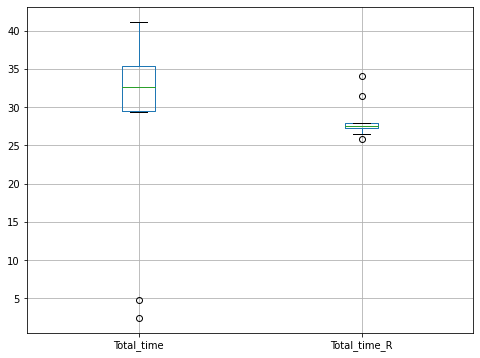

In [ ]:
import matplotlib.pyplot as plt

# Box plot of ACS In person vs. Remote
plt.figure(figsize=(8, 6))
times.boxplot(column=['Total_time', 'Total_time_R'])

plt.show()

# b.	A student’s t-test for everyone 
15 has In-person, 12 has remote

In [ ]:
stats.ttest_ind(IP.Time, RM.Time, equal_var=False)

Ttest_indResult(statistic=0.20035278021433628, pvalue=0.8438373446453864)

In [ ]:
pd.merge(IP, RM, how= 'outer', on='PIN')

,PIN,Time_x,Time_y
0,EPRC_00032,36.33,27.20
1,EPRC_00160,35.68,31.40
2,EPRC_00162,33.65,NaN
3,EPRC_00173,42.67,NaN
4,EPRC_00179,30.22,27.92
5,EPRC_00181,31.72,27.35
6,EPRC_00380,33.48,27.92
7,EPRC_00550,40.23,NaN
8,EPSF_00832,29.32,26.47
9,EPSF_00836,2.42,27.62


#c.	Correlations between remote and in-person- Total Time
There are only 5 students both have in person and remote

In [ ]:
import numpy as np
import scipy.stats as stats

stats.pearsonr(times['Total_time'], times['Total_time_R'])    # Pearson's correlation coefficient and p-value 

(0.509924450288285, 0.1321358593288217)

In [ ]:
time_breakdown = pd.concat([mni,mnr]) 

#d.	Does it take longer for remote vs. in-person? - Total Time


In [ ]:
stats.wilcoxon(times.Total_time, times.Total_time_R, alternative='two-sided')

WilcoxonResult(statistic=19.0, pvalue=0.3862707203664827)

In [ ]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,36.33,27.20
1,EPRC_00160,35.68,31.40
2,EPRC_00179,30.22,27.92
3,EPRC_00181,31.72,27.35
4,EPRC_00380,33.48,27.92
5,EPSF_00832,29.32,26.47
6,EPSF_00836,2.42,27.62
7,EPSF_00847,4.77,25.82
8,EPSF_00944,41.20,34.08
9,EPSF_01666,34.62,27.55


# e.	Plot on x-axis remote scores for all the Inst, and plot on y-axis all the in-person 

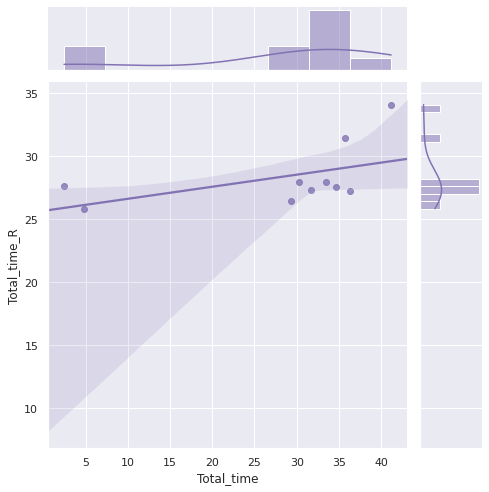

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="Total_time", y="Total_time_R", data=times,
                  kind="reg", truncate=False,
                  color="m", height=7)

#Composites (age-corrected and fully-corrected scores)Scores

In [ ]:
#  get all files from all In-person subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/In Person/*CB_Scores.csv')


doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

df = pd.concat(doc)

In [ ]:
df.shape

(88, 28)

In [ ]:
df['PIN'] = df['PIN'].str[7:17]

In [ ]:
keep =['PIN', 'Inst', 'RawScore', 'Theta', 'SE',
       'ItmCnt', 'Computed Score',
       'Uncorrected Standard Score', 'Age-Corrected Standard Score',
       'National Percentile (age adjusted)', 'Fully-Corrected T-score',
       'InstrumentBreakoff', 'InstrumentStatus2']

In [ ]:
df=df[keep]

In [ ]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,36.33,27.20
1,EPRC_00160,35.68,31.40
2,EPRC_00179,30.22,27.92
3,EPRC_00181,31.72,27.35
4,EPRC_00380,33.48,27.92
5,EPSF_00832,29.32,26.47
6,EPSF_00836,2.42,27.62
7,EPSF_00847,4.77,25.82
8,EPSF_00944,41.20,34.08
9,EPSF_01666,34.62,27.55


In [ ]:
#Differentiate the rows contain Composites
comp =df[df['Inst'].str.contains("Composite")]
raw =df[~df['Inst'].str.contains("Composite")]

In [ ]:
raw=raw.dropna(axis=1, how='all')
raw.head()

In [ ]:
comp=comp.dropna(axis=1, how='all')
comp.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
7,EPRC_00032,Cognition Fluid Composite v1.1,93,103,59,48
8,EPRC_00032,Cognition Crystallized Composite v1.1,71,85,16,32
9,EPRC_00032,Cognition Total Composite Score v1.1,78,93,32,38
10,EPRC_00032,Cognition Early Childhood Composite v1.1,89,105,62,48
7,EPRC_00160,Cognition Fluid Composite v1.1,94,109,73,49


In [ ]:
comp.Inst.unique()

array(['Cognition Fluid Composite v1.1',
       'Cognition Crystallized Composite v1.1',
       'Cognition Total Composite Score v1.1',
       'Cognition Early Childhood Composite v1.1'], dtype=object)

In [ ]:
df['Mode'] ='In Person'

In [ ]:
#  get all files from all Remote subdirectories

all_files = glob.glob('/content/gdrive/My Drive/Avera/Rapid City/*/Remote/*CB_Scores_R.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

dfr = pd.concat(doc)

In [ ]:
dfr.shape

(54, 28)

In [ ]:
dfr['PIN'] = dfr['PIN'].str[7:17]

In [ ]:
dfr=dfr[keep]

In [ ]:
dfr

In [ ]:
#Differentiate the rows contain Composites
comp_r =dfr[dfr['Inst'].str.contains("Composite")]
raw_r =dfr[~dfr['Inst'].str.contains("Composite")]

In [ ]:
raw_r=raw_r.dropna(axis=1, how='all')
raw_r.head()

In [ ]:
comp_r=comp_r.dropna(axis=1, how='all')
comp_r.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
6,EPRC_00032,Cognition Crystallized Composite v1.1,74.0,85.0,16.0,38.0
7,EPRC_00032,Cognition Early Childhood Composite v1.1,85.0,98.0,44.0,43.0
6,EPRC_00160,Cognition Crystallized Composite v1.1,83.0,106.0,66.0,51.0
7,EPRC_00160,Cognition Early Childhood Composite v1.1,79.0,92.0,29.0,42.0
6,EPRC_00173,Cognition Crystallized Composite v1.1,63.0,72.0,3.0,39.0


In [ ]:
comp_r.columns =['PIN', 'Inst', 'Uncorrected Standard Score_r',
       'Age-Corrected Standard Score_r', 'National Percentile (age adjusted)_r',
       'Fully-Corrected T-score_r']

In [ ]:
dfr['Mode'] = 'Remote'

In [ ]:
scores = pd.merge(comp, comp_r, on=["PIN",'Inst'])

In [ ]:
scores.shape

(8, 10)

# a.	A matched t-test for those who have both in-person and remote 

In [ ]:
df.Inst.unique()

array(['NIH Toolbox Picture Vocabulary Test Age 3+ v2.1',
       'NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1',
       'NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1',
       'NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1',
       'Cognition Fluid Composite v1.1',
       'Cognition Crystallized Composite v1.1',
       'Cognition Total Composite Score v1.1',
       'Cognition Early Childhood Composite v1.1'], dtype=object)

In [ ]:
#For matched ones there are only two composite
scores.Inst.unique()

array(['Cognition Crystallized Composite v1.1',
       'Cognition Early Childhood Composite v1.1'], dtype=object)

In [ ]:
#Differentiate the rows contain Composites
ccc =scores[scores['Inst'].str.contains('Cognition Crystallized Composite')]
cecc =scores[scores['Inst'].str.contains('Cognition Early Childhood Composite')]

In [ ]:
keep1=['PIN', 'Inst', 
       'Age-Corrected Standard Score', 
       'Fully-Corrected T-score',
       'Age-Corrected Standard Score_r',
   'Fully-Corrected T-score_r']

In [ ]:
ccc[keep1]

,PIN,Inst,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
0,EPRC_00032,Cognition Crystallized Composite v1.1,85,32,85.0,38.0
2,EPRC_00160,Cognition Crystallized Composite v1.1,99,42,106.0,51.0
4,EPRC_00173,Cognition Crystallized Composite v1.1,85,45,72.0,39.0
5,EPRC_00179,Cognition Crystallized Composite v1.1,106,55,113.0,54.0
6,EPRC_00181,Cognition Crystallized Composite v1.1,100,46,100.0,37.0


In [ ]:
cecc[keep1]

,PIN,Inst,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
1,EPRC_00032,Cognition Early Childhood Composite v1.1,105,48,98.0,43.0
3,EPRC_00160,Cognition Early Childhood Composite v1.1,106,43,92.0,42.0
7,EPRC_00181,Cognition Early Childhood Composite v1.1,87,36,89.0,34.0


In [ ]:
#Cognition Crystallized Composite 
stats.ttest_ind(ccc['Age-Corrected Standard Score'], ccc['Age-Corrected Standard Score_r'], equal_var = False)

Ttest_indResult(statistic=-0.023401818860045786, pvalue=0.982044921318919)

In [ ]:
stats.ttest_ind(cecc['Age-Corrected Standard Score'], cecc['Age-Corrected Standard Score_r'], equal_var = False)

Ttest_indResult(statistic=0.942954167272383, pvalue=0.42192821094451066)

In [ ]:
stats.ttest_ind(ccc['Fully-Corrected T-score'], ccc['Fully-Corrected T-score_r'], equal_var = False)

Ttest_indResult(statistic=0.03874921291460697, pvalue=0.9700406260552642)

In [ ]:
stats.ttest_ind(cecc['Fully-Corrected T-score'], cecc['Fully-Corrected T-score_r'], equal_var = False)

Ttest_indResult(statistic=0.5929994533288819, pvalue=0.586259799376224)

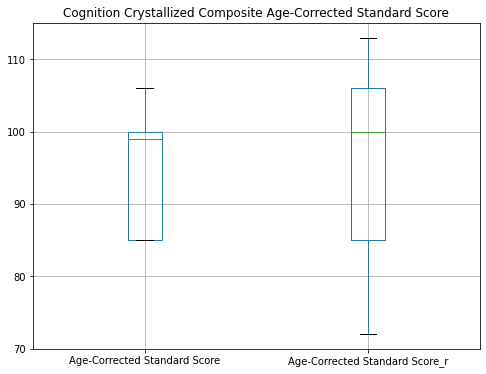

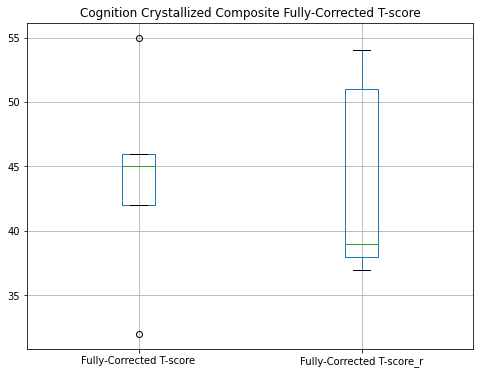

In [ ]:
import matplotlib.pyplot as plt
# Box plot of ACS In person vs. Remote
plt.figure(figsize=(8, 6))
ccc.boxplot(column=['Age-Corrected Standard Score', 'Age-Corrected Standard Score_r'])
plt.title('Cognition Crystallized Composite Age-Corrected Standard Score')

plt.figure(figsize=(8, 6))
ccc.boxplot(column=['Fully-Corrected T-score', 'Fully-Corrected T-score_r'])
plt.title('Cognition Crystallized Composite Fully-Corrected T-score')

plt.show()

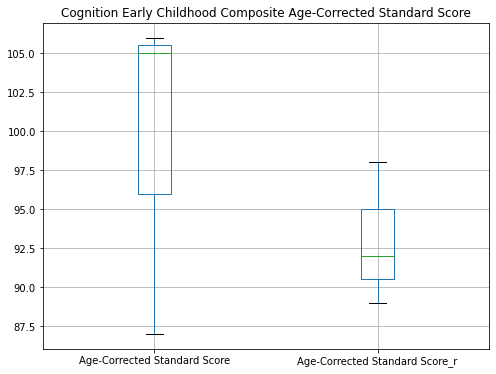

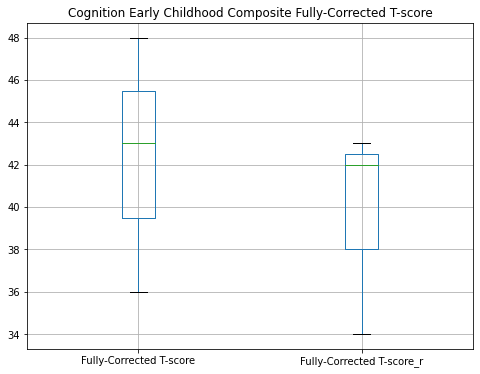

In [ ]:


# Box plot of CECC (age and fully)  In person vs. Remote
plt.figure(figsize=(8, 6))
cecc.boxplot(column=['Age-Corrected Standard Score', 'Age-Corrected Standard Score_r'])
plt.title('Cognition Early Childhood Composite Age-Corrected Standard Score')

plt.figure(figsize=(8, 6))
cecc.boxplot(column=['Fully-Corrected T-score', 'Fully-Corrected T-score_r'])

plt.title('Cognition Early Childhood Composite Fully-Corrected T-score')
plt.show()

# b.	A student’s t-test for everyone 

In [ ]:
#Differentiate the rows contain Composites
ccc =comp[comp['Inst'].str.contains('Cognition Crystallized Composite')]
cecc =scores[scores['Inst'].str.contains('Cognition Early Childhood Composite')]

In [ ]:
comp_r.Inst.unique()
#Since remote data only has CCC and CECC

array(['Cognition Crystallized Composite v1.1',
       'Cognition Early Childhood Composite v1.1'], dtype=object)

In [ ]:
stats.ttest_ind(comp[comp['Inst'].str.contains('Cognition Crystallized Composite')]['Age-Corrected Standard Score'],comp_r[comp_r['Inst'].str.contains('Cognition Crystallized Composite')]['Age-Corrected Standard Score_r'], equal_var=False)

Ttest_indResult(statistic=-0.2571767857225991, pvalue=0.8030937233383489)

In [ ]:
stats.ttest_ind(comp[comp['Inst'].str.contains('Cognition Early Childhood Composite')]['Fully-Corrected T-score'], comp_r[comp_r['Inst'].str.contains('Cognition Early Childhood Composite')]['Fully-Corrected T-score_r'], equal_var=False)

Ttest_indResult(statistic=0.616154154698851, pvalue=0.551845028333277)

# c.	Correlations between remote and in-person

In [ ]:
stats.pearsonr(ccc['Age-Corrected Standard Score'], ccc['Age-Corrected Standard Score_r'])

(0.946587402616624, 0.014699039823178852)

In [ ]:
stats.pearsonr(cecc['Fully-Corrected T-score'], cecc['Fully-Corrected T-score_r'])

(0.947287987151735, 0.20762342012113136)

# d.	Does it take longer for remote vs. in-person? 

In [ ]:
stats.wilcoxon(ccc['Age-Corrected Standard Score'], ccc['Age-Corrected Standard Score_r'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=3.0, pvalue=1.0)

In [ ]:
stats.wilcoxon(cecc['Fully-Corrected T-score'], cecc['Fully-Corrected T-score_r'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)

# e.	Plot on x-axis remote scores for all the Inst, and plot on y-axis all the in-person 

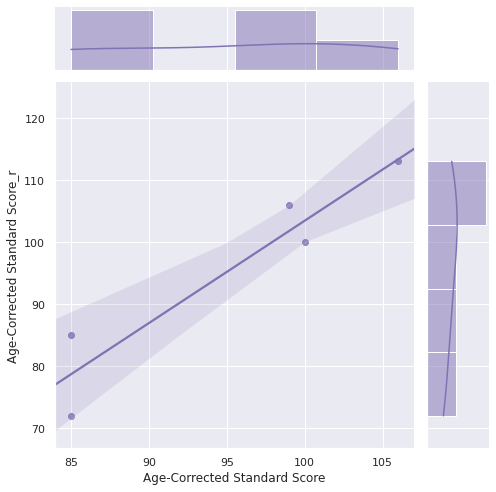

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="Age-Corrected Standard Score", y="Age-Corrected Standard Score_r", data=ccc,
                  kind="reg", truncate=False,
                  color="m", height=7)

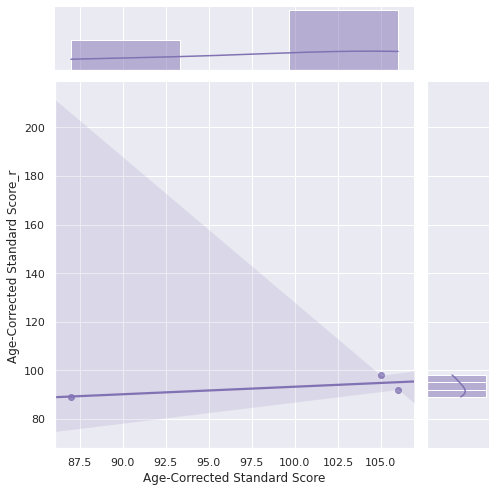

In [ ]:

g = sns.jointplot(x="Age-Corrected Standard Score", y="Age-Corrected Standard Score_r", data=cecc,
                  kind="reg", truncate=False,
                  color="m", height=7)

# Wide to Long

In [ ]:
all = pd.concat([df,dfr]) 

In [ ]:
time_breakdown.head()

,PIN,Inst,Date,Time,Mode
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,2021-03-30,5.30,In Person
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,2021-03-30,3.97,In Person
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,2021-03-30,10.60,In Person
3,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,2021-03-30,1.43,In Person
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,2021-03-30,1.57,In Person


In [ ]:
rv =pd.merge(time_breakdown, all, how='outer',on=['PIN','Inst','Mode'])

In [ ]:
rv.shape

(258, 16)

In [ ]:
rv['Site'] = np.where(rv['PIN'].str.contains('SF'), 'Sioux Falls', 'Rapid City')

In [ ]:
all.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2,Mode
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-2.411,0.475,20.0,NaN,71.0,95.0,36.0,36.0,2.0,3.0,In Person
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,20.0,NaN,NaN,24.0,7.24,89.0,94.0,34.0,45.0,2.0,3.0,In Person
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,16.0,NaN,NaN,15.0,NaN,97.0,108.0,69.0,48.0,2.0,3.0,In Person
3,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,26.0,NaN,NaN,38.0,6.73,91.0,96.0,40.0,46.0,2.0,3.0,In Person
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,34.0,NaN,NaN,34.0,39.00,80.0,86.0,18.0,39.0,2.0,3.0,In Person


In [ ]:
rv = rv.melt(id_vars=['PIN','Inst','Mode','Date','Time','Site'], 
        var_name="Scores", 
        value_name="Value")

In [ ]:
rv=rv.dropna(thresh=6, axis=0)

In [ ]:
rv.shape

(2502, 8)

In [ ]:
rv.to_csv('long_format_data.csv', index=False)